In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import recall_score, classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif

In [58]:
df = pd.read_csv('../data/heart_disease_clean.csv', index_col='id')

In [59]:
df.drop(['heart_disease_prediction', 'dataset'], axis=1, inplace=True)
df.head()

,age,sex,chest_pain_type,blood_pressure_resting,cholesterol,fasting_blood_sugar,ecg_resting,max_heart_rate,exercise_induced_angina,st_depression_exercise,st_slope_type,major_vessels_colored,thal_defect_type,sick
id,,,,,,,,,,,,,,
1,63,Male,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
2,67,Male,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,1
3,67,Male,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
4,37,Male,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
5,41,Female,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [60]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

non_numeric_cols = df.select_dtypes(exclude=['number']).columns.tolist()

for col in non_numeric_cols:
    le = LabelEncoder()
    df[f'{col}_Encoded'] = le.fit_transform(df[col])
    df.drop(col, axis=1, inplace=True)
    # print("Label Encoding output:\n", df)


In [61]:
import os
output_dir = '../data/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
df.to_csv(os.path.join(output_dir, 'heart_disease_numerical.csv'))
print(f"\nProcessed data saved to '{os.path.join(output_dir, 'heart_disease_numerical.csv')}'")



Processed data saved to '../data/heart_disease_numerical.csv'


In [62]:
X, y = df.drop('sick', axis=1), df['sick']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (209, 13)
X_test shape: (90, 13)
y_train shape: (209,)
y_test shape: (90,)


In [63]:
# Check the distribution of 'sick' in train and test sets
print("\n'sick' distribution in y_train:")
print(y_train.value_counts(normalize=True))
print("\n'sick' distribution in y_test:")
print(y_test.value_counts(normalize=True))


'sick' distribution in y_train:
sick
0    0.535885
1    0.464115
Name: proportion, dtype: float64

'sick' distribution in y_test:
sick
0    0.533333
1    0.466667
Name: proportion, dtype: float64


## Feature Scaling

In [64]:
scaler = StandardScaler()

# Fit on training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames with proper column names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

## Model Training

We will train several classification models: RandomForestClassifier (scale-insensitive), KNeighborsClassifier, LogisticRegression, and Support Vector Classifier (SVC) (scale-sensitive).


In [65]:
# 1. Random Forest Classifier (Scale-Insensitive)
print("Training Random Forest Classifier...")
forest = RandomForestClassifier(random_state=42) # Add random_state for reproducibility
forest.fit(X_train, y_train)
print("Random Forest Classifier trained.")

# 2. K-Nearest Neighbors Classifier (Scale-Sensitive)
print("\nTraining K-Nearest Neighbors Classifier...")
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)
print("K-Nearest Neighbors Classifier trained.")

# 3. Logistic Regression (Scale-Sensitive)
print("\nTraining Logistic Regression...")
log = LogisticRegression(random_state=42, solver='liblinear') # Add random_state and solver
log.fit(X_train_scaled, y_train)
print("Logistic Regression trained.")

# 4. Support Vector Classifier (SVC) (Scale-Sensitive)
print("\nTraining Support Vector Classifier...")
svc = SVC(random_state=42, probability=True) # probability=True for ROC AUC later
svc.fit(X_train_scaled, y_train)
print("Support Vector Classifier trained.")


Training Random Forest Classifier...
Random Forest Classifier trained.

Training K-Nearest Neighbors Classifier...
K-Nearest Neighbors Classifier trained.

Training Logistic Regression...
Logistic Regression trained.

Training Support Vector Classifier...
Support Vector Classifier trained.


## Initial Model Evaluation (Before Tuning)

In [66]:
print("--- Initial Model Scores (Accuracy) ---")
print(f"Random Forest Accuracy: {forest.score(X_test, y_test):.3f}")
print(f"K-Nearest Neighbors Accuracy: {knn.score(X_test_scaled, y_test):.3f}")
print(f"Logistic Regression Accuracy: {log.score(X_test_scaled, y_test):.3f}")
print(f"Support Vector Classifier Accuracy: {svc.score(X_test_scaled, y_test):.3f}")


--- Initial Model Scores (Accuracy) ---
Random Forest Accuracy: 0.789
K-Nearest Neighbors Accuracy: 0.778
Logistic Regression Accuracy: 0.856
Support Vector Classifier Accuracy: 0.822


In [67]:
# It's also good to see recall, especially for medical diagnoses where false negatives can be critical.
print("\n--- Initial Model Scores (Recall) ---")

y_preds_forest = forest.predict(X_test)
print(f"Random Forest Recall: {recall_score(y_test, y_preds_forest):.3f}")

y_preds_knn = knn.predict(X_test_scaled)
print(f"K-Nearest Neighbors Recall: {recall_score(y_test, y_preds_knn):.3f}")

y_preds_log = log.predict(X_test_scaled)
print(f"Logistic Regression Recall: {recall_score(y_test, y_preds_log):.3f}")

y_preds_svc = svc.predict(X_test_scaled)
print(f"Support Vector Classifier Recall: {recall_score(y_test, y_preds_svc):.3f}")


--- Initial Model Scores (Recall) ---
Random Forest Recall: 0.667
K-Nearest Neighbors Recall: 0.690
Logistic Regression Recall: 0.810
Support Vector Classifier Recall: 0.714


## Hyperparameter Tuning with GridSearchCV

In [68]:
# Random Forest tuning
print("\nTuning Random Forest Classifier...")
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Using 'recall' as the scoring metric for medical diagnosis, as minimizing false negatives is often crucial.
# If you want to optimize for overall accuracy, keep 'accuracy'.
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='recall', n_jobs=-1, verbose=1)
rf_grid.fit(X_train, y_train)

print("\nRandom Forest Best Parameters:", rf_grid.best_params_)
print(f"Random Forest Best Score (Recall on CV):  {rf_grid.best_score_:.3f}")
best_forest_model = rf_grid.best_estimator_



Tuning Random Forest Classifier...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Random Forest Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Random Forest Best Score (Recall on CV):  0.786


In [69]:
# KNN tuning
print("\nTuning K-Nearest Neighbors Classifier...")
knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring='recall', n_jobs=-1, verbose=1)
knn_grid.fit(X_train_scaled, y_train)

print("\nKNN Best Parameters:", knn_grid.best_params_)
print(f"KNN Best Score (Recall on CV): {knn_grid.best_score_:.3f}")
best_knn_model = knn_grid.best_estimator_


Tuning K-Nearest Neighbors Classifier...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

KNN Best Parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}
KNN Best Score (Recall on CV): 0.775


In [70]:
# Logistic Regression tuning
print("\nTuning Logistic Regression Classifier...")
log_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs'],
    'penalty': ['l1', 'l2'] # l1 only with liblinear
}

# Filter out incompatible combinations
log_params_filtered = []

# Combinations for 'liblinear' solver
for C_val in log_params['C']:
    for penalty_val in log_params['penalty']:
        log_params_filtered.append({
            'C': [C_val], # <<<< --- CRITICAL CHANGE: Wrap C_val in a list
            'solver': ['liblinear'],
            'penalty': [penalty_val] # <<<< --- CRITICAL CHANGE: Wrap penalty_val in a list
        })

# Combinations for 'lbfgs' solver (only supports l2 penalty)
for C_val in log_params['C']:
    log_params_filtered.append({
        'C': [C_val], # <<<< --- CRITICAL CHANGE: Wrap C_val in a list
        'solver': ['lbfgs'],
        'penalty': ['l2'] # <<<< --- CRITICAL CHANGE: 'l2' is already a string, but for consistency, still wrap if part of a single-item list
    })

# You can optionally print log_params_filtered to verify its structure
# print(log_params_filtered)

log_grid = GridSearchCV(LogisticRegression(random_state=42, max_iter=1000), log_params_filtered, cv=5, scoring='recall', n_jobs=-1, verbose=1)
log_grid.fit(X_train_scaled, y_train)

print("\nLogistic Regression Best Parameters:", log_grid.best_params_)
print(f"Logistic Regression Best Score (Recall on CV): {log_grid.best_score_:.3f}")
best_log_model = log_grid.best_estimator_


Tuning Logistic Regression Classifier...
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Logistic Regression Best Parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Logistic Regression Best Score (Recall on CV): 0.766


In [71]:
# SVC tuning
print("\nTuning SVC Classifier...")
svc_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svc_grid = GridSearchCV(SVC(random_state=42, probability=True), svc_params, cv=5, scoring='recall', n_jobs=-1, verbose=1)
svc_grid.fit(X_train_scaled, y_train)

print("\nSVC Best Parameters:", svc_grid.best_params_)
print(f"SVC Best Score (Recall on CV): {svc_grid.best_score_:.3f}")
best_svc_model = svc_grid.best_estimator_



Tuning SVC Classifier...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

SVC Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
SVC Best Score (Recall on CV): 0.775


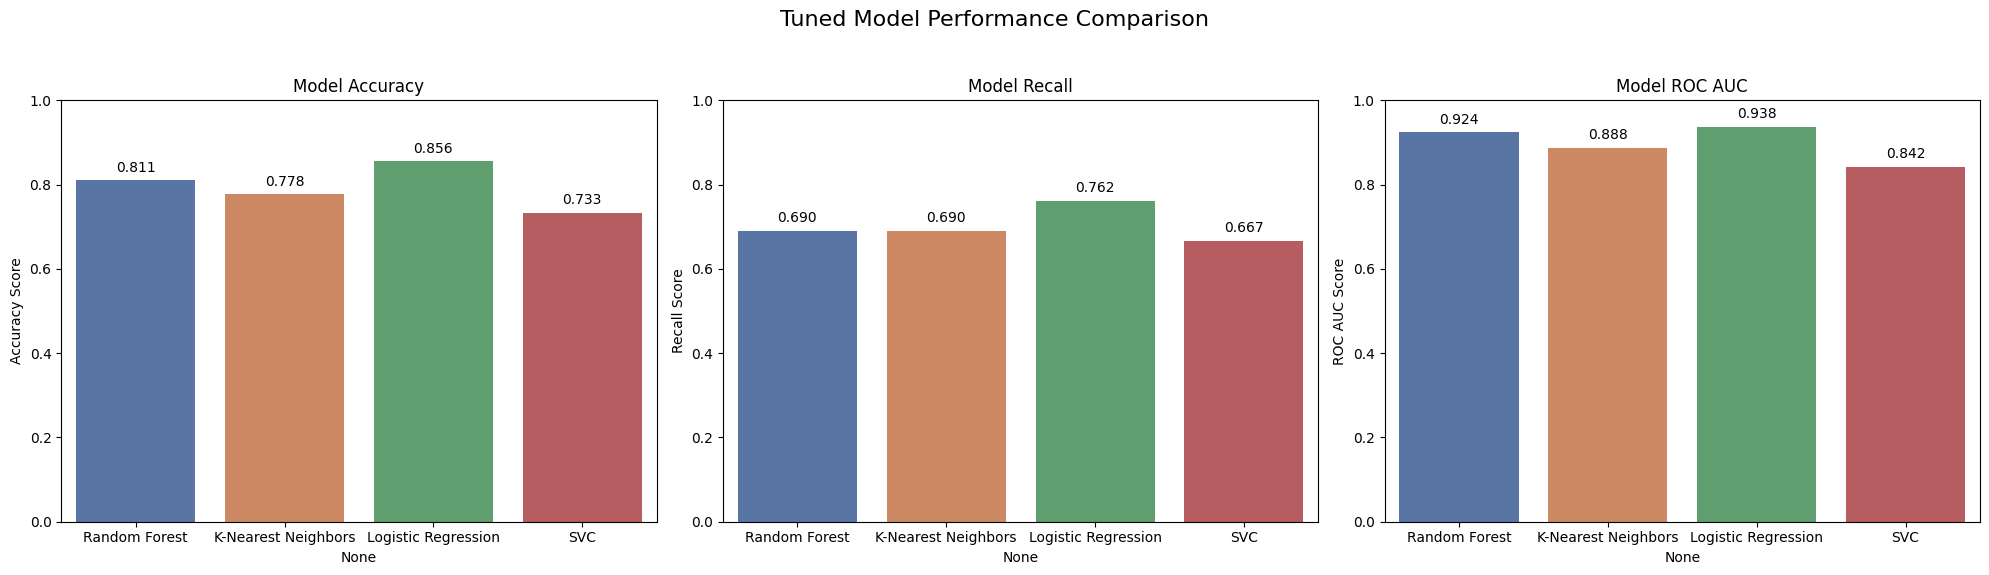


--- Confusion Matrices ---


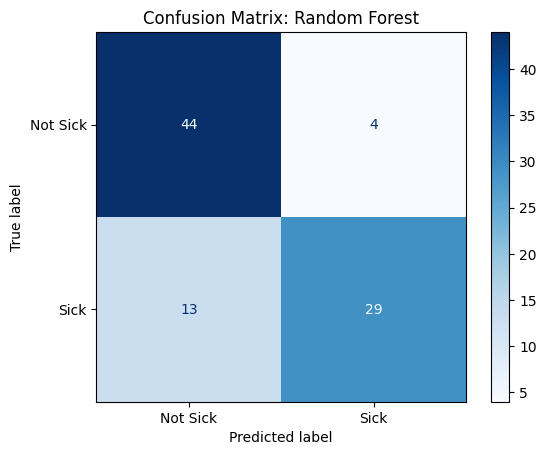

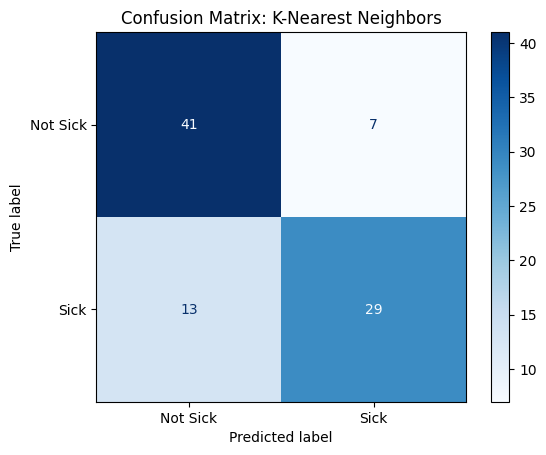

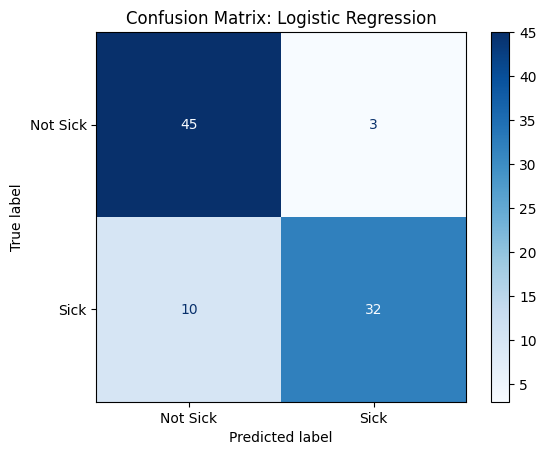

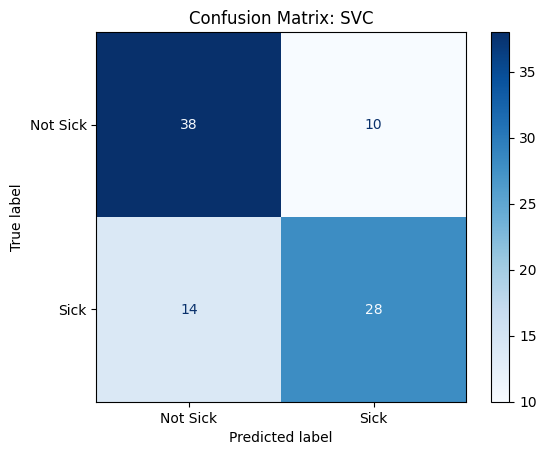


--- Summary of Tuned Model Performance on Test Set ---
                     Accuracy  Recall  ROC AUC
Random Forest           0.811   0.690    0.924
K-Nearest Neighbors     0.778   0.690    0.888
Logistic Regression     0.856   0.762    0.938
SVC                     0.733   0.667    0.842

Model with Highest Recall:
Logistic Regression (0.762)


In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import recall_score, accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Ensure the models are defined from previous cells (running the full notebook)
# If you're running this section separately, make sure these models are available in your environment:
# best_forest_model, best_knn_model, best_log_model, best_svc_model
# X_test, y_test, X_test_scaled

# Define the models and their corresponding test data
models = {
    "Random Forest": {"model": best_forest_model, "X_test": X_test},
    "K-Nearest Neighbors": {"model": best_knn_model, "X_test": X_test_scaled},
    "Logistic Regression": {"model": best_log_model, "X_test": X_test_scaled},
    "SVC": {"model": best_svc_model, "X_test": X_test_scaled}
}

# Dictionaries to store metrics
accuracy_scores = {}
recall_scores = {}
roc_auc_scores = {}

# Calculate metrics for each model
for name, data in models.items():
    model = data["model"]
    X_test_data = data["X_test"]
    
    y_pred = model.predict(X_test_data)
    
    accuracy_scores[name] = accuracy_score(y_test, y_pred)
    recall_scores[name] = recall_score(y_test, y_pred)
    
    # Check for predict_proba for ROC AUC
    if hasattr(model, 'predict_proba'):
        try:
            y_pred_proba = model.predict_proba(X_test_data)[:, 1]
            roc_auc_scores[name] = roc_auc_score(y_test, y_pred_proba)
        except AttributeError:
            roc_auc_scores[name] = np.nan # Not applicable
            print(f"Warning: {name} does not support predict_proba for ROC AUC calculation.")
    else:
        roc_auc_scores[name] = np.nan # Not applicable

# Convert to pandas Series for easy plotting
accuracy_series = pd.Series(accuracy_scores)
recall_series = pd.Series(recall_scores)
roc_auc_series = pd.Series(roc_auc_scores)

# %% [markdown]
# ### 10.1 Comparison of Accuracy, Recall, and ROC AUC

# %%
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Tuned Model Performance Comparison', fontsize=16)

# Accuracy Plot
sns.barplot(x=accuracy_series.index, y=accuracy_series.values, ax=axes[0], hue=accuracy_series.index, palette='deep')
axes[0].set_title('Model Accuracy')
axes[0].set_ylabel('Accuracy Score')
axes[0].set_ylim(0, 1)
for index, value in enumerate(accuracy_series.values):
    axes[0].text(index, value + 0.02, f'{value:.3f}', ha='center')

# Recall Plot
sns.barplot(x=recall_series.index, y=recall_series.values, ax=axes[1], hue=recall_series.index, palette='deep')
axes[1].set_title('Model Recall')
axes[1].set_ylabel('Recall Score')
axes[1].set_ylim(0, 1)
for index, value in enumerate(recall_series.values):
    axes[1].text(index, value + 0.02, f'{value:.3f}', ha='center')

# ROC AUC Plot
# Filter out NaNs if some models don't have predict_proba
roc_auc_filtered_series = roc_auc_series.dropna()
if not roc_auc_filtered_series.empty:
    sns.barplot(x=roc_auc_filtered_series.index, y=roc_auc_filtered_series.values, ax=axes[2], hue=roc_auc_filtered_series.index, palette='deep')
    axes[2].set_title('Model ROC AUC')
    axes[2].set_ylabel('ROC AUC Score')
    axes[2].set_ylim(0, 1)
    for index, value in enumerate(roc_auc_filtered_series.values):
        axes[2].text(index, value + 0.02, f'{value:.3f}', ha='center')
else:
    axes[2].set_title('Model ROC AUC (Not Available)')
    axes[2].text(0.5, 0.5, "No models support predict_proba for ROC AUC", 
                 horizontalalignment='center', verticalalignment='center', transform=axes[2].transAxes)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()


# %% [markdown]
# ### 10.2 Confusion Matrices for Each Model

# %%
# Function to plot confusion matrix
def plot_confusion_matrix(model, X_test_data, y_test_data, title):
    y_pred = model.predict(X_test_data)
    cm = confusion_matrix(y_test_data, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Sick', 'Sick'])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f'Confusion Matrix: {title}')
    plt.show()

# Plot confusion matrices for each model
print("\n--- Confusion Matrices ---")
for name, data in models.items():
    plot_confusion_matrix(data["model"], data["X_test"], y_test, name)

# %% [markdown]
# ### 10.3 Combined Performance Table

# %%
# Create a DataFrame to summarize all metrics
performance_df = pd.DataFrame({
    'Accuracy': accuracy_series,
    'Recall': recall_series,
    'ROC AUC': roc_auc_series
})

print("\n--- Summary of Tuned Model Performance on Test Set ---")
print(performance_df.round(3))

# Highlight the best recall score (or other preferred metric)
print("\nModel with Highest Recall:")
print(performance_df['Recall'].idxmax(), f"({performance_df['Recall'].max():.3f})")

# %%